## Imports

In [51]:
import numpy as np
import matplotlib.patches as patches
import matplotlib.pyplot as plt


# Sample Function

Let's define a simple function `f(x)` that we'd like to approximate. We'll take `n` samples uniformly spaced along the x-axis in the range from `(x0, x1)` and store the x and y coordinates in the variables `x`, and `y`,

Note that if you change the definition of `f(x)`, you may also have to adjust `x0`, `x1`, and `n` to get a representative
# set of samples over an interesting domain.

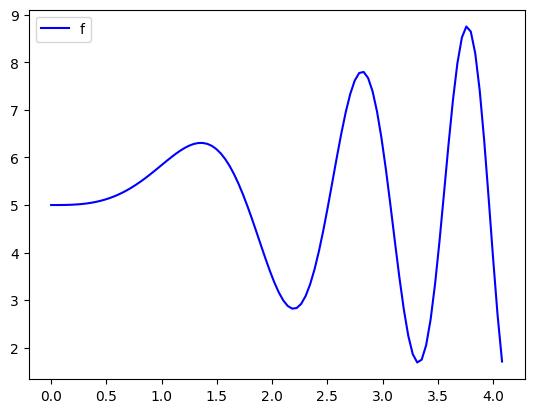

In [131]:
f = lambda x: np.sin(x**2) * x + 5

x0 = 0    # Left side of domain
x1 = 4    # Right side of domain
n = 100   # Number of samples

x = np.linspace(x0, x1 + (x1 - x0) * 2 / n, n + 2)
y = np.vectorize(f)(x)

plt.plot(x, y, label="f", color="blue")
plt.legend()
plt.show()

# Piecewise-Linear Approximation

We'll use a naive algorithm to generate a continuous, piecewise linear function that approximates `f(x)`, with a bias towards shorter line segments in regions where the slope of `f(x)` changes more rapidly.

This approximation will be stored in `segments`.

Note that if you change the definition of `f(x)` you may need to adjust the `error_total` and `error_max` parameters to get a decent approximation.

Approximating function f(x) with 32 linear segments.


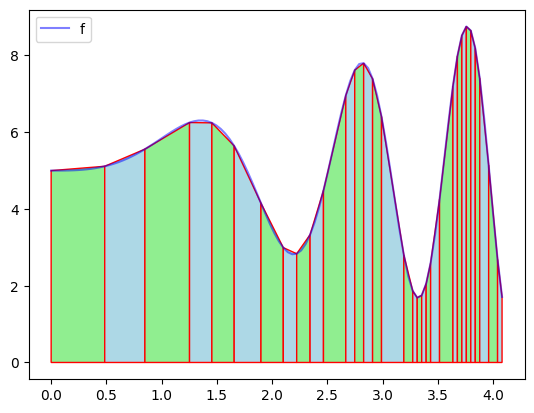

In [134]:
def compute_errors(x, y, i, j):
    if j - i == 1:
        return (0, 0, 0)
    m = (y[j - 1] - y[i]) / (x[j - 1] - x[i])
    b = y[i]
    errors = [abs((m * (x[k] - x[i])) + b - y[k]) for k in range(i, j)]
    return np.mean(errors), np.sum(errors), np.max(errors)


# Finds the longest run where the average error is less than epsilon
def next_piece(x, y, epsilon_total, epsilon_max, i):
    best_piece = None
    j = i + 1
    while j <= len(x):
        error = compute_errors(x, y, i, j)
        mean, total, max = error
        
        if total > epsilon_total:
            break
        if max > epsilon_max:
            break
        best_piece = (i, j, error)
        j += 1
    return best_piece


def piecewise(x, y, epsilon_total, epsilon_max, pieces):
    i = 0
    while i < len(x) - 1:
        piece = next_piece(x, y, epsilon_total, epsilon_max, i)
        pieces.append(piece)
        i = piece[1] - 1
    return pieces


# segments = piecewise(x, y, 0.05, [])
segments = piecewise(x, y, 0.35, .1, [])

fig, ax = plt.subplots()
for i, s in enumerate(segments):
    vertices = [
        (x[s[0]], 0),
        (x[s[0]], y[s[0]]),
        (x[s[1] - 1], y[s[1] - 1]),
        (x[s[1] - 1], 0),
    ]
    color = "lightgreen" if i % 2 == 0 else "lightblue"
    polygon = patches.Polygon(
        vertices, closed=True, fill=True, edgecolor="r", facecolor=color
    )
    ax.add_patch(polygon)

print(f"Approximating function f(x) with {len(segments)} linear segments.")

plt.plot(x, y, label="f", color="blue", alpha=0.5)
# plt.scatter([x[s[0]] for s in segments], [y[s[0]] for s in segments], color="red", label="Training samples")
plt.legend()
plt.show()

## Building a deep learning model to approximate `f(x)`

We can get a good approximation of `f(x)` using a model with two [dense layers](https://en.wikipedia.org/wiki/Layer_(deep_learning)), the first of which will use [RELU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) activation.

In [ ]:
def relu(x):
  return max(0.0, x)

def build_model(segments):
  m1 = []
  b1 = []
  m2 = []

  for segment in segments:
    start, slope, end = segment
    if (slope >= 0):
      m1.append(slope)
      b1.append(-slope * start)
      m2.append(1)

      m1.append(slope)
      b1.append(-slope * end)
      m2.append(-1)
    else:
      m1.append(-slope)
      b1.append(slope * start)
      m2.append(-1)

      m1.append(-slope)
      b1.append(slope * end)
      m2.append(1)

  def f(x):
    dot = [relu(m1[i] * x + b1[i]) for i in range(len(m1))]
    sum = 0
    for i in range(0, len(dot)):
        sum += dot[i] * m2[i]
    # sum = 0
    # for i in range(0, len(m1), 2):
    #   sum += relu(m1[i] * x + b1[i])
    #   sum -= relu(m1[i + 1] * x + b1[i + 1])
    return sum
  
  return f


# PyTorch Model

In [ ]:
import torch
import torch.nn as nn

class CustomModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, weights1, weights2):
        super(CustomModel, self).__init__()
        
        # Define two linear layers
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, output_size)
        
        # Initialize weights using the arrays provided
        self.layer1.weight = nn.Parameter(torch.tensor(weights1, dtype=torch.float32))
        self.layer2.weight = nn.Parameter(torch.tensor(weights2, dtype=torch.float32))

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        return x

# Function to create the model
def create_model(input_size, hidden_size, output_size, weights1, weights2):
    model = CustomModel(input_size, hidden_size, output_size, weights1, weights2)
    return model


### Parameters:
* input_size: Number of input features.
* hidden_size: Number of neurons in the hidden layer.
* output_size: Number of neurons in the output layer.
* weights1: Array to initialize weights for the first layer.
* weights2: Array to initialize weights for the second layer.

### Usage Example

This will create a model with two layers, initialize weights as specified, and apply ReLU activations between layers. Adjust input_size, hidden_size, and output_size as necessary for your specific use case.

In [ ]:
# Define model dimensions
input_size = 4
hidden_size = 5
output_size = 3

# Define custom weights for each layer
weights1 = [[0.1, 0.2, 0.3, 0.4], [0.5, 0.6, 0.7, 0.8], [0.9, 0.1, 0.2, 0.3], [0.4, 0.5, 0.6, 0.7], [0.8, 0.9, 0.1, 0.2]]
weights2 = [[0.1, 0.2, 0.3, 0.4, 0.5], [0.6, 0.7, 0.8, 0.9, 0.1], [0.2, 0.3, 0.4, 0.5, 0.6]]

# Create the model
model = create_model(input_size, hidden_size, output_size, weights1, weights2)
